# Practica Machine Learning -> Roberto Martinez Camacho

Librerias.

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap
%matplotlib inline

from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

import graphviz

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

Funciones.

In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

### Lo primero que vamos hacer antes de dividir en train/test, como es un dataset que conocemos y vamos a trabajar con los registros de Madrid y aunque no tenemos muchos registros de otras ciudades, prefiero eliminar dichos registros antes para que la proporcion train/test no se vea desbalanceada con registros que vamos a eliminar si o si en algun momento.

In [3]:
full_df = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')
full_df['City'].value_counts()

Madrid         13207
Barcelona        292
London           132
Paris            108
马德里               52
               ...  
Malaga             1
Provensals         1
Ses Salines        1
Sencelles          1
Ventas             1
Name: City, Length: 246, dtype: int64

Vemos que existen mas lugares distintos a Madrid, nos quedamos solamente con los registros que buscamos.

In [4]:
full_df = full_df.drop(full_df[full_df['City']!='Madrid'].index)
full_df['City'].value_counts()

Madrid    13207
Name: City, dtype: int64

### Dividimos en parte de "train" "test"

In [5]:
train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con la parte él. 
data = pd.read_csv('./train.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (10565, 89)
Dimensiones del dataset de test: (2642, 89)


### ANALISIS Y EXPLORACION DE LOS DATOS
Hacemos un primer analisis "visual" de los datos

In [6]:
data.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,13270355,https://www.airbnb.com/rooms/13270355,20170407214119,2017-04-08,Madrid Center Sunny Appartment,"Places of interest: CaixaForum Madrid, Barrio ...","Nice appartment in the center of Madrid, with ...","Places of interest: CaixaForum Madrid, Barrio ...",none,NaN,...,10.0,9.0,9.0,NaN,NaN,flexible,2.0,7.63,"40.4110160191,-3.69965649095","Host Has Profile Pic,Host Identity Verified,Re..."
1,8991818,https://www.airbnb.com/rooms/8991818,20170407214119,2017-04-08,ROOMS IN MADRID,ROOMS FOR RENT IN MADRID. FOR ERASMUS STUDENS ...,NaN,ROOMS FOR RENT IN MADRID. FOR ERASMUS STUDENS ...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,1.0,NaN,"40.4247850244,-3.65830048851","Host Has Profile Pic,Requires License"
2,5310107,https://www.airbnb.com/rooms/5310107,20170407214119,2017-04-08,Attic with terrace Madrid city center -WIFI- cozy,Attic with a marvellous terrace on top. WIFI V...,Home has been reciently reformed. There plent...,Attic with a marvellous terrace on top. WIFI V...,none,"Right in the city center of Madrid, at Barrio ...",...,10.0,10.0,9.0,NaN,NaN,moderate,2.0,2.28,"40.4151910492,-3.69859147994","Host Has Profile Pic,Host Identity Verified,Is..."
3,16144069,https://www.airbnb.com/rooms/16144069,20170407214119,2017-04-08,1.- Studio Private ÓPERA/SOL. With Balcony,"This cozy studio of 18mts 2, is completely ref...",NaN,"This cozy studio of 18mts 2, is completely ref...",none,Calle muy privilegiada y céntrica (Calle del A...,...,9.0,10.0,9.0,NaN,NaN,moderate,6.0,2.97,"40.4189857656,-3.70727564846","Host Has Profile Pic,Is Location Exact,Require..."
4,13445117,https://www.airbnb.com/rooms/13445117,20170407214119,2017-04-08,Habitación para una persona o dos,Mi alojamiento es bueno para parejas y aventur...,NaN,Mi alojamiento es bueno para parejas y aventur...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,1.0,0.10,"40.4058653456,-3.67647489861","Host Has Profile Pic,Host Identity Verified,Is..."


Vemos comos nos daba el dato de la dimension que tenemos muchas columnas (89) y algunas con demasiada informacion de caracter, url...vamos a analizar algo mas detalladamente las columnas para ver en un primer rastreo cual podemos eliminar.

Listamos el ID, nombre y tipo de las columnas para tener localizado a la hora de hacer drop()

In [7]:
for i in range (len(data.columns.values)):
    print("Columna:", i, data.columns.values[i], "es: ", data.iloc[:, i].dtype)

Columna: 0 ID es:  int64
Columna: 1 Listing Url es:  object
Columna: 2 Scrape ID es:  int64
Columna: 3 Last Scraped es:  object
Columna: 4 Name es:  object
Columna: 5 Summary es:  object
Columna: 6 Space es:  object
Columna: 7 Description es:  object
Columna: 8 Experiences Offered es:  object
Columna: 9 Neighborhood Overview es:  object
Columna: 10 Notes es:  object
Columna: 11 Transit es:  object
Columna: 12 Access es:  object
Columna: 13 Interaction es:  object
Columna: 14 House Rules es:  object
Columna: 15 Thumbnail Url es:  object
Columna: 16 Medium Url es:  object
Columna: 17 Picture Url es:  object
Columna: 18 XL Picture Url es:  object
Columna: 19 Host ID es:  int64
Columna: 20 Host URL es:  object
Columna: 21 Host Name es:  object
Columna: 22 Host Since es:  object
Columna: 23 Host Location es:  object
Columna: 24 Host About es:  object
Columna: 25 Host Response Time es:  object
Columna: 26 Host Response Rate es:  float64
Columna: 27 Host Acceptance Rate es:  float64
Columna: 

Con el siguiente proceso intento analizar algo mas cada columna para ver si se trata de url, o que tenga mucha informacion de caracter o que tipo de información numerica nos da, nos fijaremos detenidamente en las variables de tipo 'object' para las que no podamos categorizar por tener demasiada informacion y al escapar aún de todos mis conocimientos las excluyamos.

(Mi intencion al intento del comienzo de la practica es hacer algo con la columna 'Amenities' o ' Featerures o 'Host Verifications'

In [8]:
for i in range (len(data.columns.values)):
    print("-----------------------------------------------")
    print("----------INICIO INFORMACION COLUMNA-----------")
    print('\n',data[data.columns.values[i]].value_counts())
    print("Indice: ",i)
    print("-----------------FIN COLUMNA-------------------")

-----------------------------------------------
----------INICIO INFORMACION COLUMNA-----------

 13780991    1
9776551     1
12416420    1
5227938     1
14800288    1
           ..
16216763    1
16022202    1
704122      1
9334804     1
14019121    1
Name: ID, Length: 10565, dtype: int64
Indice:  0
-----------------FIN COLUMNA-------------------
-----------------------------------------------
----------INICIO INFORMACION COLUMNA-----------

 https://www.airbnb.com/rooms/14758697    1
https://www.airbnb.com/rooms/15711041    1
https://www.airbnb.com/rooms/15899424    1
https://www.airbnb.com/rooms/5740305     1
https://www.airbnb.com/rooms/12861209    1
                                        ..
https://www.airbnb.com/rooms/1039376     1
https://www.airbnb.com/rooms/12600312    1
https://www.airbnb.com/rooms/4912382     1
https://www.airbnb.com/rooms/14012779    1
https://www.airbnb.com/rooms/5625653     1
Name: Listing Url, Length: 10565, dtype: int64
Indice:  1
-----------------FIN C


 1.0      4583
2.0      1671
3.0       899
4.0       554
5.0       322
6.0       255
8.0       191
10.0      184
9.0       175
7.0       147
11.0      130
15.0      107
164.0     100
12.0       79
14.0       76
46.0       76
114.0      74
13.0       74
38.0       67
40.0       63
142.0      61
207.0      51
32.0       50
17.0       47
26.0       46
20.0       45
16.0       44
39.0       41
57.0       38
24.0       37
51.0       36
18.0       34
68.0       28
34.0       27
36.0       23
28.0       22
30.0       22
23.0       18
0.0        14
25.0       11
22.0       11
21.0       10
45.0        9
35.0        4
27.0        3
136.0       1
50.0        1
265.0       1
81.0        1
Name: Host Listings Count, dtype: int64
Indice:  31
-----------------FIN COLUMNA-------------------
-----------------------------------------------
----------INICIO INFORMACION COLUMNA-----------

 1.0      4583
2.0      1671
3.0       899
4.0       554
5.0       322
6.0       255
8.0       191
10.0      184
9.

In [9]:
#Esto es por si quiero ver algun indice en concreto si no recuerdo bien la informacion de la columna.

index_col = 39
var_aux_indexName = data.columns.values[index_col]
print(var_aux_indexName)
data[var_aux_indexName].value_counts()

State


Comunidad de Madrid             8512
Community of Madrid             1482
Madrid                           514
España                             4
Spain                              3
madrid                             2
Communauté de Madrid               2
MADRID                             2
Madrid capital                     1
28                                 1
Espańa                             1
Usera                              1
Madrid \nMadrid                    1
Autonome Gemeinschaft Madrid       1
Name: State, dtype: int64

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10565.0,1.042161e+07,5.495137e+06,1.862800e+04,5.938004e+06,1.155134e+07,1.533683e+07,1.810984e+07
Scrape ID,10565.0,2.017041e+13,0.000000e+00,2.017041e+13,2.017041e+13,2.017041e+13,2.017041e+13,2.017041e+13
Host ID,10565.0,3.751608e+07,3.437059e+07,1.745300e+04,7.657596e+06,2.761147e+07,5.761493e+07,1.247534e+08
Host Response Rate,9225.0,9.483762e+01,1.534975e+01,0.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
Host Acceptance Rate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Host Listings Count,10563.0,9.476569e+00,2.658725e+01,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,2.650000e+02
Host Total Listings Count,10563.0,9.476569e+00,2.658725e+01,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,2.650000e+02
Latitude,10565.0,4.042068e+01,2.015124e-02,4.033291e+01,4.041011e+01,4.041882e+01,4.042791e+01,4.051425e+01
Longitude,10565.0,-3.697294e+00,2.335170e-02,-3.835498e+00,-3.707852e+00,-3.701568e+00,-3.693932e+00,-3.573613e+00
Accommodates,10565.0,3.182773e+00,1.986991e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01


Las variables que vamos a eliminar las hemos seleccionado en funcion a la informacion que tenian, urls, columnas con todos los datos iguales, algunas con muy pocos datos y que no eran en mi mi primer analisis relevantes, o algunas con demasiada informacion tipo str.

Listamos el nombre de las columnas para poder ir seleccionando las que vamos a dropear.

In [11]:
data.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

In [12]:
aux_colums_toDrop = ['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 
                     'Experiences Offered', 'Notes', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url', 
                     'State', 'Market', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 'Host Location', 
                     'Host About', 'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url', 'Host Verifications', 
                     'Street','Smart Location', 'Country Code', 'Country', 'Weekly Price', 'Monthly Price', 
                     'Minimum Nights', 'Has Availability', 'Calendar last Scraped', 'First Review', 'Last Review', 
                     'License', 'Jurisdiction Names', 'Geolocation']

data = data.drop(aux_colums_toDrop, axis=1)
print(len(aux_colums_toDrop))
data.shape

40


(10565, 49)

In [13]:
#Movemos la columna objetivo que en este caso es "price" a la primera posición del dataframe.
data = data.reindex(columns=(['Price'] + list([a for a in data.columns if a != 'Price']) ))
data.head(1)

,Price,Neighborhood Overview,Transit,Access,Interaction,Host Since,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,...,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Features
0,55.0,NaN,NaN,"Complete access to a fully equipped kitchen, w...",Will be available for you during all your stay...,2016-05-30,within an hour,100.0,NaN,2.0,...,9.0,8.0,10.0,10.0,9.0,9.0,flexible,2.0,7.63,"Host Has Profile Pic,Host Identity Verified,Re..."


### MIRAR OUTLIERS
Creo que en este problema nos podemos centrar solamente en los outliers de la variable objetivo, si fuera necesario otro analisis sobre outliers en otra variable lo realizare mas adelante.

In [14]:
data['Price'].value_counts()

50.0     491
60.0     428
25.0     424
30.0     419
35.0     356
        ... 
218.0      1
239.0      1
536.0      1
434.0      1
470.0      1
Name: Price, Length: 266, dtype: int64

In [15]:
data['Price'].describe()

count    10558.000000
mean        65.771832
std         56.347456
min          9.000000
25%         31.000000
50%         52.000000
75%         80.000000
max        875.000000
Name: Price, dtype: float64

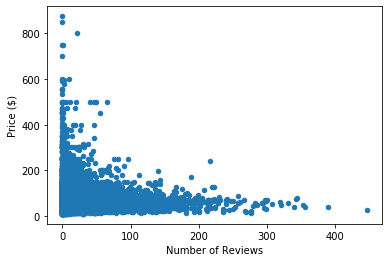

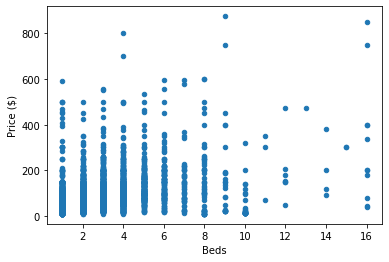

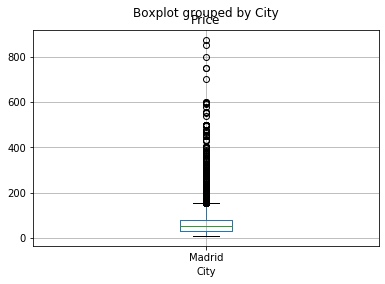

In [16]:
data.plot(kind = 'scatter',x='Number of Reviews',y = 'Price')
plt.xlabel('Number of Reviews')
plt.ylabel('Price ($)')
plt.show()

data.plot(kind = 'scatter',x='Beds',y = 'Price')
plt.xlabel('Beds')
plt.ylabel('Price ($)')
plt.show()

data.boxplot(by='City',column = 'Price')
plt.show()

Por la informacion que nos da describe() y por lo que visualizamos en los graficos, vamos a considerar los registros a partir de 600 como un outlier, y los eliminaremos del dataframe.

In [17]:
my_filter = data['Price'] <= 600
data = data[my_filter]
data['Price'].describe()

count    10552.000000
mean        65.361448
std         53.650317
min          9.000000
25%         31.000000
50%         52.000000
75%         80.000000
max        600.000000
Name: Price, dtype: float64

Continuamos analizando los datos con las funciones conocidas.

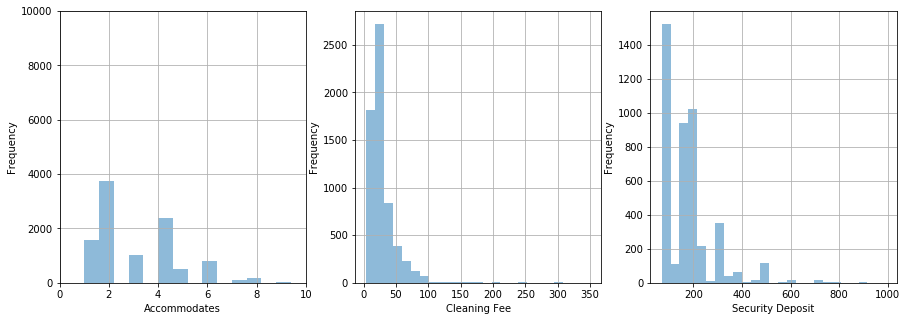

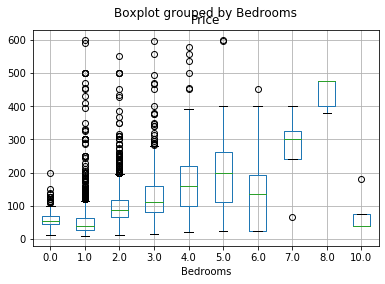

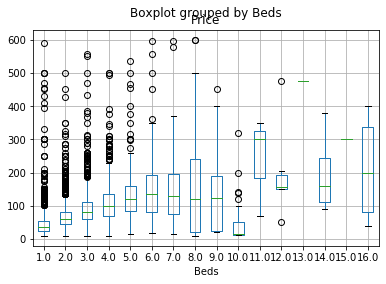

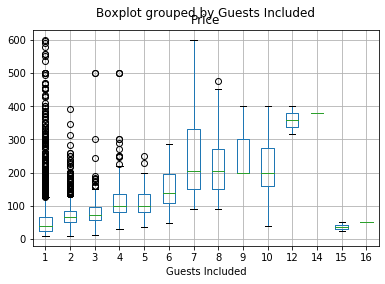

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
data['Accommodates'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.axis([0, 10, 0, 10000])
plt.xlabel('Accommodates')

plt.subplot(1,3,2)
data['Cleaning Fee'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Cleaning Fee')

plt.subplot(1,3,3)
data['Security Deposit'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Security Deposit')

data.boxplot(by='Bedrooms',column = 'Price')
data.boxplot(by='Beds',column = 'Price')
data.boxplot(by='Guests Included',column = 'Price')

plt.show()

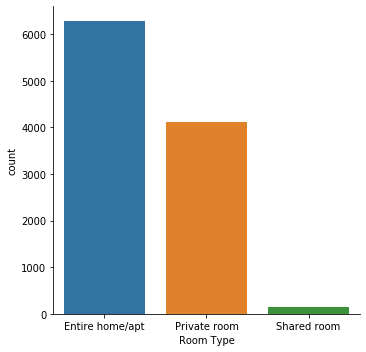

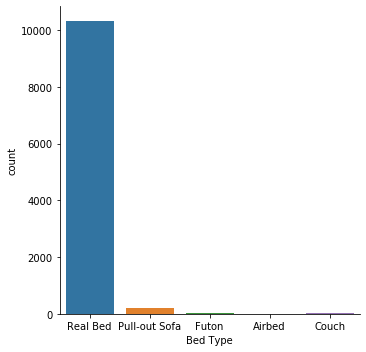

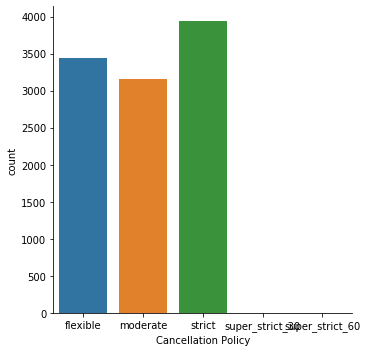

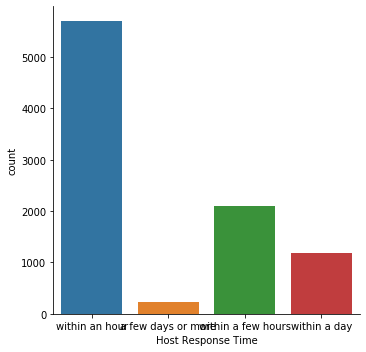

In [19]:
sns.factorplot('Room Type',data=data,kind="count")
sns.factorplot('Bed Type',data=data,kind="count")
sns.factorplot('Cancellation Policy',data=data,kind="count")
sns.factorplot('Host Response Time',data=data,kind="count")

Vamos hacer una exploracion a la correlacion entre varianzas.

In [20]:
data.corr()

,Price,Host Response Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,...,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
Price,1.000000,0.005466,0.186254,0.186254,0.060363,-0.022056,0.574785,0.320629,0.504741,0.479077,...,-0.028424,0.058741,0.058019,0.090881,-0.008260,0.003571,0.150670,0.021634,0.155300,-0.058657
Host Response Rate,0.005466,1.000000,-0.034472,-0.034472,-0.039353,-0.029273,0.072190,-0.034801,0.024717,0.043014,...,0.134181,0.091834,0.071154,0.108568,0.096069,0.076030,0.044375,0.090634,-0.058797,0.182980
Host Listings Count,0.186254,-0.034472,1.000000,1.000000,0.003926,-0.036310,0.124283,0.160569,0.071046,0.083138,...,-0.090462,-0.187741,-0.135316,-0.061472,-0.252482,-0.229675,-0.020554,-0.162116,0.922596,-0.121562
Host Total Listings Count,0.186254,-0.034472,1.000000,1.000000,0.003926,-0.036310,0.124283,0.160569,0.071046,0.083138,...,-0.090462,-0.187741,-0.135316,-0.061472,-0.252482,-0.229675,-0.020554,-0.162116,0.922596,-0.121562
Latitude,0.060363,-0.039353,0.003926,0.003926,1.000000,0.258842,-0.003377,0.044743,0.030927,0.012717,...,-0.059263,0.005413,0.010605,-0.003769,0.012695,0.005882,0.048833,0.002140,0.009518,-0.065486
Longitude,-0.022056,-0.029273,-0.036310,-0.036310,0.258842,1.000000,-0.050452,0.009948,0.009667,-0.025583,...,-0.025709,0.039571,0.037737,0.040128,0.022218,0.024380,-0.080121,0.027447,-0.039868,-0.004325
Accommodates,0.574785,0.072190,0.124283,0.124283,-0.003377,-0.050452,1.000000,0.306197,0.670231,0.820075,...,0.088545,-0.066282,-0.068270,-0.020855,-0.065583,-0.056216,0.043276,-0.061885,0.124776,0.051858
Bathrooms,0.320629,-0.034801,0.160569,0.160569,0.044743,0.009948,0.306197,1.000000,0.406527,0.368413,...,-0.058805,0.013242,0.008393,0.009341,-0.041204,-0.037050,0.038205,0.004179,0.180478,-0.059918
Bedrooms,0.504741,0.024717,0.071046,0.071046,0.030927,0.009667,0.670231,0.406527,1.000000,0.684765,...,-0.018928,0.012773,0.003044,0.010015,-0.014365,-0.002061,0.001405,0.003490,0.063847,-0.040522
Beds,0.479077,0.043014,0.083138,0.083138,0.012717,-0.025583,0.820075,0.368413,0.684765,1.000000,...,0.041430,-0.055474,-0.070360,-0.025812,-0.049689,-0.041941,0.006143,-0.052454,0.091554,-0.007965


Vamos a pintar la correlacion entre variables para ver si tenemos que dropear alguna variable mas.

Pista: Se puede hacer de varias formas


Eliminar la que tenga menos correlacion con la variable objetivo.


O un selector de caracteristicas implicito que se ve en la segunda parte de la clase 3.


Hacer un modelo con cada uno de las variables y comparar.

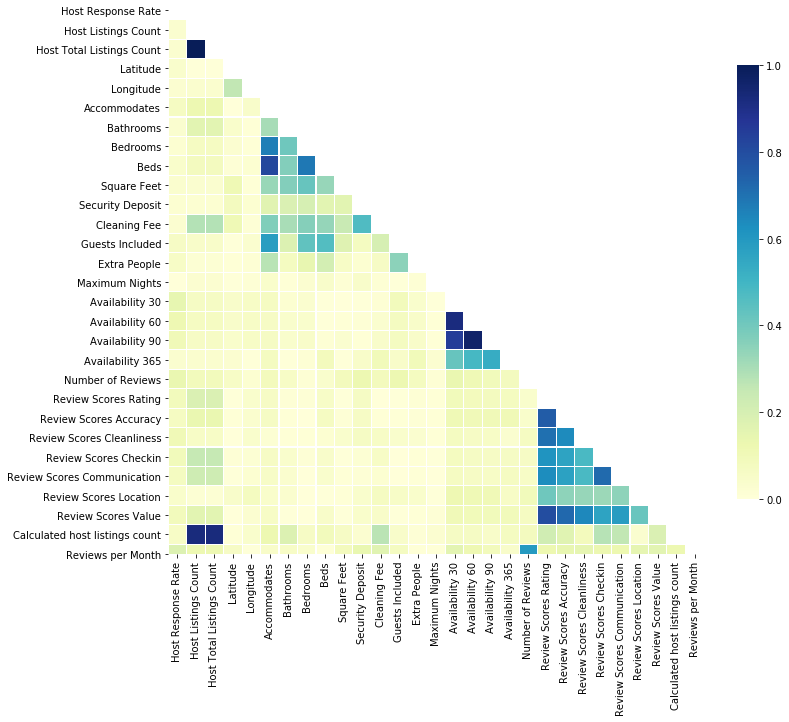

In [21]:
# Compute the correlation matrix
corr = np.abs(data.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Compruebo que existen ciertas variables con una informacion muy parecida que tienen muy fuerte correlacion y concretamente 2 de ellas estan muy relacionadas con otro par de variables:



'Host Total Count' con 'Host Total Listings Count' y con 'Calculated host listings count' (que a su vez lo tienen entre ellas, eliminamos ambas)


'Availability 30' con 'Availability 60' y con 'Availability 90' (que a su vez lo tienen entre ellas, eliminamos ambas)

In [22]:
data = data.drop(['Host Total Listings Count', 'Calculated host listings count', 'Availability 60',
       'Availability 90'], 
                 axis=1)
data.shape

(10552, 45)

Compruebo que los valores a imputar en 'Square Feet' son muchos, y con la varianza que veiamos anteriormente no quiero realizar drop() pero voy a tener que hacerlo, aunque la considero una variable muy importante para la variables objetivo.


No me ha quedado tiempo para hacer un estudio como en la practica de estadistica e intentar rellenar con algo mas aproximado los valores ausentes de esta variable.

In [23]:
data = data.drop(['Square Feet'],axis=1)
data.shape

(10552, 44)

### IMPUTAR VALORES AUSENTES

In [24]:
aux_cont_null_True = 0
for i in range (len(data.columns.values)):
    if data[data.columns.values[i]].isnull().any() == True:
        aux_cont_null_True += 1
print("Columnas totales: ",len(data.columns.values))
print("Columnas con valores ausentes: " ,aux_cont_null_True)
print("Columnas con datos completos: ", len(data.columns.values) - aux_cont_null_True, "\n")

data.isnull().any()

Columnas totales:  44
Columnas con valores ausentes:  25
Columnas con datos completos:  19 



Price                           False
Neighborhood Overview            True
Transit                          True
Access                           True
Interaction                      True
Host Since                       True
Host Response Time               True
Host Response Rate               True
Host Neighbourhood               True
Host Listings Count              True
Neighbourhood                    True
Neighbourhood Cleansed          False
Neighbourhood Group Cleansed    False
City                            False
Zipcode                          True
Latitude                        False
Longitude                       False
Property Type                   False
Room Type                       False
Accommodates                    False
Bathrooms                        True
Bedrooms                         True
Beds                             True
Bed Type                        False
Amenities                        True
Security Deposit                 True
Cleaning Fee

In [25]:
# Columnas que no tienen todos los valores.

for i in range (len(data.columns.values)):
    if data[data.columns.values[i]].isnull().any() == True:
        print(data[data.columns.values[i]].describe())
        print("--------------------")

count                                                  6645
unique                                                 5836
top       Se trata de una de las zonas más emblemáticas ...
freq                                                     28
Name: Neighborhood Overview, dtype: object
--------------------
count                                                  6589
unique                                                 5779
top       It is calm, quite zone and you don’t have to s...
freq                                                     26
Name: Transit, dtype: object
--------------------
count                                                  5994
unique                                                 5183
top       Wifi, TV, washing machine, Microwave, full equ...
freq                                                     35
Name: Access, dtype: object
--------------------
count                                                  6018
unique                                                 48

In [26]:
#Columnas que si tienen todos los valores.

for i in range (len(data.columns.values)):
    if data[data.columns.values[i]].isnull().any() == False:
        print(data[data.columns.values[i]].describe())
        print("--------------------")

count    10552.000000
mean        65.361448
std         53.650317
min          9.000000
25%         31.000000
50%         52.000000
75%         80.000000
max        600.000000
Name: Price, dtype: float64
--------------------
count           10552
unique            125
top       Embajadores
freq             1435
Name: Neighbourhood Cleansed, dtype: object
--------------------
count      10552
unique        21
top       Centro
freq        5392
Name: Neighbourhood Group Cleansed, dtype: object
--------------------
count      10552
unique         1
top       Madrid
freq       10552
Name: City, dtype: object
--------------------
count    10552.000000
mean        40.420661
std          0.020144
min         40.332908
25%         40.410114
50%         40.418816
75%         40.427889
max         40.514247
Name: Latitude, dtype: float64
--------------------
count    10552.000000
mean        -3.697309
std          0.023341
min         -3.835498
25%         -3.707853
50%         -3.701575
75%     

He comprobado (y quizas puedo estar equivocado) que las variables 'Neighborhood Overview' , 'Transit', 'Interaction' tienen muchos valores unicos y con mucha informacion de tipo str, vamos a realizar drop tambien ya que creo que con los conocimientos que tengo no puedo sacar nada claro.

In [27]:
data = data.drop(['Neighborhood Overview' , 'Transit', 'Interaction'],axis=1)
data.shape

(10552, 41)

He considerado rellenar las siguientes columnas con 0 en donde creo que podria ser importante o no la columna si tenia esa informacion por ejemplo Amenities.

No podia rellenar un barrio que no fuera el correcto con otro distinto por eso le asigno 0 tambien a la columna como 'Neighbourhood' o por ejemplo, los que no tienen 'Security Deposit' he considerado que NO lo piden en la reserva como el 'Cleaning Fee'.

He considerado en el resto de variables rellenar con la media practicamente todas, menos con la moda que he decidido unas cuantas variables de tipo 'object' que quizas podria ser mejor.

In [28]:
#data['Amenities'].fillna('0', inplace=True)

data['Access'].fillna(0, inplace=True)
data['Zipcode'].fillna(0, inplace=True)
data['Host Neighbourhood'].fillna(0, inplace=True)
data['Security Deposit'].fillna(0, inplace=True)
data['Cleaning Fee'].fillna(0, inplace=True)

In [29]:
data['Neighbourhood'].fillna('Unknown', inplace=True)

In [30]:
data['Amenities'].fillna(data['Amenities'].mode()[0], inplace=True)
data['Host Response Time'].fillna(data['Host Response Time'].mode()[0], inplace=True)
data['Host Response Rate'].fillna(data['Host Response Rate'].mode()[0], inplace=True)
data['Host Since'].fillna(data['Host Response Rate'].mode()[0], inplace=True)

In [31]:
data['Host Listings Count'].fillna(data['Host Listings Count'].mean(), inplace=True)
data['Bathrooms'].fillna(data['Bathrooms'].mean(), inplace=True)
data['Bedrooms'].fillna(data['Bedrooms'].mean(), inplace=True)
data['Beds'].fillna(data['Beds'].mean(), inplace=True)

data['Review Scores Rating'].fillna(data['Review Scores Rating'].mean(), inplace=True)
data['Review Scores Accuracy'].fillna(data['Review Scores Accuracy'].mean(), inplace=True)
data['Review Scores Cleanliness'].fillna(data['Review Scores Cleanliness'].mean(), inplace=True)
data['Review Scores Checkin'].fillna(data['Review Scores Checkin'].mean(), inplace=True)
data['Review Scores Communication'].fillna(data['Review Scores Communication'].mean(), inplace=True)
data['Review Scores Location'].fillna(data['Review Scores Location'].mean(), inplace=True)
data['Review Scores Value'].fillna(data['Review Scores Value'].mean(), inplace=True)
data['Reviews per Month'].fillna(data['Reviews per Month'].mean(), inplace=True)

In [32]:
aux_cont_null_True = 0
for i in range (len(data.columns.values)):
    if data[data.columns.values[i]].isnull().any() == True:
        aux_cont_null_True += 1
print("Columnas totales: ",len(data.columns.values))
print("Columnas con valores ausentes: " ,aux_cont_null_True)
print("Columnas con datos completos: ", len(data.columns.values) - aux_cont_null_True, "\n")

Columnas totales:  41
Columnas con valores ausentes:  0
Columnas con datos completos:  41 



In [33]:
data.isnull().any()

Price                           False
Access                          False
Host Since                      False
Host Response Time              False
Host Response Rate              False
Host Neighbourhood              False
Host Listings Count             False
Neighbourhood                   False
Neighbourhood Cleansed          False
Neighbourhood Group Cleansed    False
City                            False
Zipcode                         False
Latitude                        False
Longitude                       False
Property Type                   False
Room Type                       False
Accommodates                    False
Bathrooms                       False
Bedrooms                        False
Beds                            False
Bed Type                        False
Amenities                       False
Security Deposit                False
Cleaning Fee                    False
Guests Included                 False
Extra People                    False
Maximum Nigh

### GENERACION DE VARIABLES

VARIABLES NUMERICAS

In [34]:
aux_cont_objects = 0

for i in range (len(data.columns.values)):
    if data.iloc[:, i].dtype !='O':
        aux_cont_objects += 1
        aux_index_name = data.columns.values[i]
        print(data.columns.values[i], "--", len(str(data[aux_index_name].value_counts()).split(',')))
        
print("Total objects: ", aux_cont_objects)

Price -- 3
Host Response Rate -- 3
Host Listings Count -- 2
Latitude -- 3
Longitude -- 3
Accommodates -- 2
Bathrooms -- 2
Bedrooms -- 2
Beds -- 2
Security Deposit -- 3
Cleaning Fee -- 3
Guests Included -- 2
Extra People -- 2
Maximum Nights -- 3
Availability 30 -- 2
Availability 365 -- 3
Number of Reviews -- 3
Review Scores Rating -- 2
Review Scores Accuracy -- 2
Review Scores Cleanliness -- 2
Review Scores Checkin -- 2
Review Scores Communication -- 2
Review Scores Location -- 2
Review Scores Value -- 2
Reviews per Month -- 3
Total objects:  25


Creo una variable que sea el precio por una penalizacion total, si tuvieran que usar el deposito inicial y la limpieza del la vivienda (en el caso que asi fuera)

In [35]:
data['Price_Penaliced'] = data[['Price','Security Deposit','Cleaning Fee']].sum(axis=1)

In [36]:
data['Price_Penaliced'].describe()

count    10552.000000
mean       160.287055
std        153.778249
min          9.000000
25%         42.000000
50%        107.000000
75%        235.000000
max       1565.000000
Name: Price_Penaliced, dtype: float64

Realizo un drop() sobre las variables que acabo de utilizar para crear la nueva.

In [37]:
data = data.drop(['Price','Security Deposit','Cleaning Fee'],axis=1)
data.shape

(10552, 39)

In [38]:
#Movemos la columna nueva que en este caso es "Price_Penaliced" a la primera posición del dataframe.
data = data.reindex(columns=(['Price_Penaliced'] + list([a for a in data.columns if a != 'Price_Penaliced']) ))
data.head(1)

,Price_Penaliced,Access,Host Since,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,...,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Reviews per Month,Features
0,55.0,"Complete access to a fully equipped kitchen, w...",2016-05-30,within an hour,100.0,0,2.0,Unknown,Embajadores,Centro,...,88.0,9.0,8.0,10.0,10.0,9.0,9.0,flexible,7.63,"Host Has Profile Pic,Host Identity Verified,Re..."


Voy a mirar las variables tipo objeto y tipo float para ver que variables puedo generar.

In [39]:
aux_index_name = 0
aux_cont_objects = 0

for i in range (len(data.columns.values)):
    if data.iloc[:, i].dtype =='O':
        aux_cont_objects += 1
        aux_index_name = data.columns.values[i]
        print(data.columns.values[i], "--", len(str(data[aux_index_name].value_counts()).split(',')))
        
print("Total objects: ", aux_cont_objects)

Access -- 48
Host Since -- 3
Host Response Time -- 2
Host Neighbourhood -- 3
Neighbourhood -- 3
Neighbourhood Cleansed -- 3
Neighbourhood Group Cleansed -- 2
City -- 2
Zipcode -- 3
Property Type -- 2
Room Type -- 2
Bed Type -- 2
Amenities -- 125
Calendar Updated -- 2
Cancellation Policy -- 2
Features -- 231
Total objects:  16


In [40]:
#Para hacer algo con la variable Amenities y algunas de ese tipo
len(str(data['Amenities'].value_counts()).split(','))

125

In [41]:
t = pd.Series(data['Amenities']).value_counts().reset_index().values.tolist()
len(t)

9054

In [43]:
#Me daba error todo el rato este registro en concreto, no me devolvia ningun valor incluso despues de imputar algo.
#Este ha sido uno de los motivos de estar atascado.

len(str(data['Amenities'][120]).split(','))

KeyError: 120

In [ ]:
# numeric columns
#data.select_dtypes(include='float64').fillna(data.select_dtypes(include='float64').mean().iloc[0],inplace=True)

# categorical columns
#data.select_dtypes(include='object').fillna(data.select_dtypes(include='object').mode().iloc[0],inplace=True)

### CATEGORIZACION DE VARIABLES

In [44]:
data.columns

Index(['Price_Penaliced', 'Access', 'Host Since', 'Host Response Time',
       'Host Response Rate', 'Host Neighbourhood', 'Host Listings Count',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'Zipcode', 'Latitude',
       'Longitude', 'Property Type', 'Room Type', 'Accommodates', 'Bathrooms',
       'Bedrooms', 'Beds', 'Bed Type', 'Amenities', 'Guests Included',
       'Extra People', 'Maximum Nights', 'Calendar Updated', 'Availability 30',
       'Availability 365', 'Number of Reviews', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'Cancellation Policy',
       'Reviews per Month', 'Features'],
      dtype='object')

In [45]:
data = data.drop(['Access' , 'Amenities', 'Features', 'Host Since', 'Host Neighbourhood', 'Zipcode'],axis=1)
data.shape

(10552, 33)

In [46]:
mean = data['Price_Penaliced'].mean()

agg = data.groupby('Neighbourhood')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'Neighbourhood_enc'] = data['Neighbourhood'].map(smooth)


agg = data.groupby('Host Response Time')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'Host Response Time_enc'] = data['Host Response Time'].map(smooth)


agg = data.groupby('Room Type')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'Room Type_enc'] = data['Room Type'].map(smooth)


agg = data.groupby('Bed Type')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'Bed Type_enc'] = data['Bed Type'].map(smooth)


agg = data.groupby('Cancellation Policy')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'Cancellation Policy_enc'] = data['Cancellation Policy'].map(smooth)


agg = data.groupby('Property Type')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'Property Type_enc'] = data['Property Type'].map(smooth)


agg = data.groupby('Neighbourhood Cleansed')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'Neighbourhood Cleansed_enc'] = data['Neighbourhood Cleansed'].map(smooth)


agg = data.groupby('Neighbourhood Group Cleansed')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'Neighbourhood Group Cleansed_enc'] = data['Neighbourhood Group Cleansed'].map(smooth)


agg = data.groupby('Calendar Updated')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'Calendar Updated_enc'] = data['Calendar Updated'].map(smooth)


agg = data.groupby('City')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
print(smooth)
data.loc[:, 'City_enc'] = data['City'].map(smooth)

Neighbourhood
Acacias              7.428650e+05
Adelfas              5.884458e+05
Almagro              1.616521e+06
Almenara             6.275945e+05
Aluche               1.124510e+06
                         ...     
Valdeacederas        3.167707e+05
Vallehermosa         5.392157e+05
Vicálvaro            2.957645e+05
Villa de Vallecas    2.688815e+05
Villaverde           4.292003e+05
Length: 66, dtype: float64
Host Response Time
a few days or more    1.541942e+06
within a day          2.134996e+06
within a few hours    2.524379e+06
within an hour        2.563899e+06
dtype: float64
Room Type
Entire home/apt    3.482720e+06
Private room       1.122914e+06
Shared room        5.482590e+05
dtype: float64
Bed Type
Airbed           1.271611e+05
Couch            2.632679e+05
Futon            4.159831e+05
Pull-out Sofa    1.717706e+06
Real Bed         2.545416e+06
dtype: float64
Cancellation Policy
flexible           1.675056e+06
moderate           2.484027e+06
strict             3.232946e+06


In [47]:
data = data.drop(['City' , 'Calendar Updated', 'Neighbourhood Group Cleansed', 'Neighbourhood Cleansed', 'Property Type', 
                 'Cancellation Policy', 'Bed Type', 'Room Type', 'Host Response Time', 'Neighbourhood'],axis=1)
data.shape

(10552, 33)

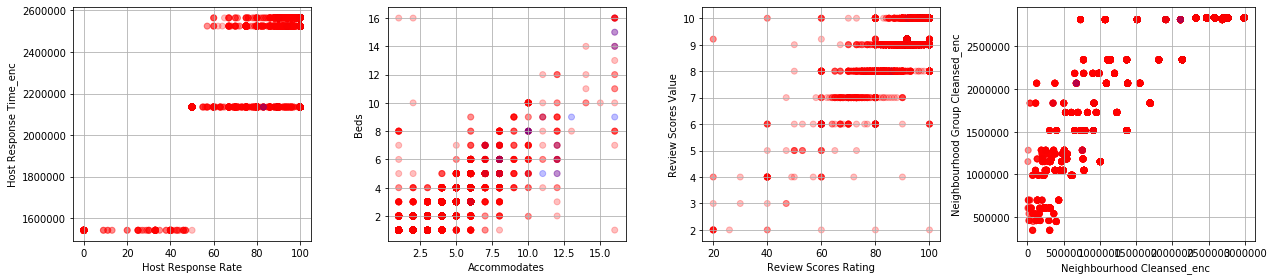

In [48]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
pairs = np.where(upper>0.76)
fx = data.columns[pairs[0]]
fy =  data.columns[pairs[1]]

i=1
plt.figure(figsize=(22,4))
for f1,f2 in zip(fx,fy):
    
    plt.subplot(1,5,i)
    
    plt.scatter(data[f1],data[f2], c=data['Price_Penaliced'],cmap=cm_bright, alpha=0.25)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.grid()
    plt.tight_layout()
    
    i+=1
    
plt.show()

### PARTE DEL MODELO

In [69]:
data_train = data.values
y_train = data_train[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data_train[:,1:]      # nos quedamos con el resto
feature_names = data.columns[1:]

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

### MODELOS 

best mean cross-validation score: -14306.102
best parameters: {'alpha': 0.46415888336127725}


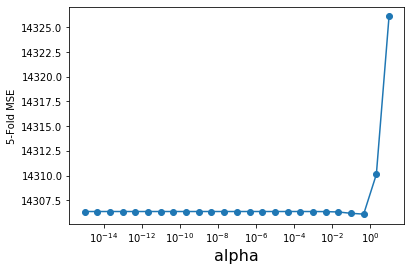

In [73]:
alpha_vector = np.logspace(-15,1,25)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Ridge(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
#plt.ylim((0, 1)) #linea comentada
plt.show()

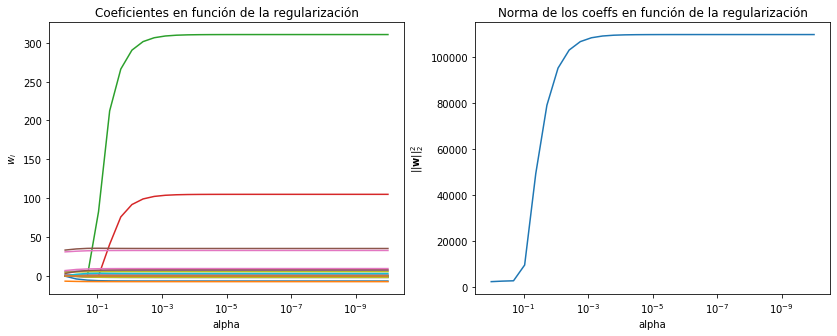

In [107]:
n_alphas = 30
alphas = np.logspace(-10, 0, n_alphas)
# ...
coefs = []

norm2_coefs = []
for a in alphas:
    lasso = Lasso(alpha = a).fit(X_train,y_train)

    coefs.append(lasso.coef_)
    norm2_coefs.append(np.dot(lasso.coef_,lasso.coef_.T))

# Display results
plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$w_i$')
plt.title('Coeficientes en función de la regularización')
plt.axis('tight')


ax = plt.subplot(1, 2, 2)
ax.plot(alphas, norm2_coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('$||\mathbf{w}||^2_2$')
plt.title('Norma de los coeffs en función de la regularización')
plt.axis('tight')
plt.show()


best mean cross-validation score: -14306.316
best parameters: {'alpha': 0.002154434690031882}


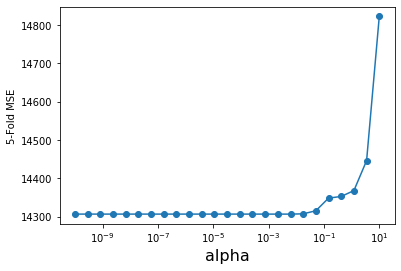

In [81]:
alpha_vector = np.logspace(-10,1,25)
# ...
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
#plt.ylim((0, 1)) #linea comentada
plt.show()

best mean cross-validation score: -14304.375
best parameters: {'alpha': 0.47148663634573934}


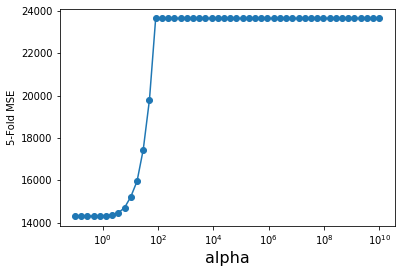

In [82]:
alpha_vector = np.logspace(-1,10,50)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

best mean cross-validation score: -15161.892
best parameters: {'alpha': 10.0}


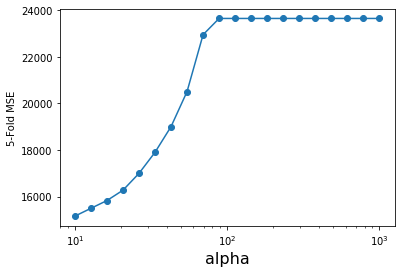

In [84]:
alpha_vector = np.logspace(1,3,20)
param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.show()

In [91]:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
print('MSE Modelo Lasso (train): ' % mseTrainModelLasso)

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 1.51e+04
Host Response Rate -0.0
Host Listings Count 0.6565549572297021
Latitude 0.0
Longitude 0.0
Accommodates 15.952057564753986
Bathrooms 15.402658058417448
Bedrooms 20.21241137882469
Beds 0.0
Guests Included 2.7428912485603956
Extra People 0.35480356162245597
Maximum Nights -0.0
Availability 30 0.0
Availability 365 0.0
Number of Reviews -0.0
Review Scores Rating 0.0
Review Scores Accuracy 0.0
Review Scores Cleanliness 1.8044563232114654
Review Scores Checkin 0.0
Review Scores Communication 0.0
Review Scores Location 0.0
Review Scores Value 0.0
Reviews per Month -4.220262210822535
Neighbourhood_enc 0.0
Host Response Time_enc 0.0
Room Type_enc 45.644186333543026
Bed Type_enc -0.0
Cancellation Policy_enc 13.217246295440107
Property Type_enc 0.0
Neighbourhood Cleansed_enc 4.352311390975639
Neighbourhood Group Cleansed_enc 0.0
Calendar Updated_enc 0.0
City_enc 0.0


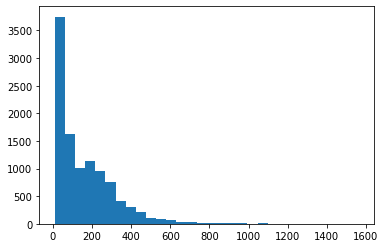

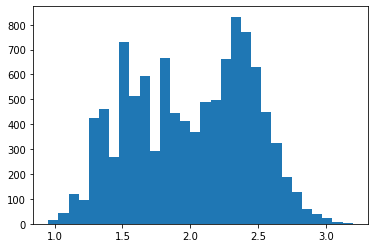

In [89]:
plt.hist(data['Price_Penaliced'], bins=30)
plt.show()

plt.hist(np.log10(data['Price_Penaliced']), bins=30)
plt.show()

best mean cross-validation score: 0.377
best parameters: {'max_depth': 6}


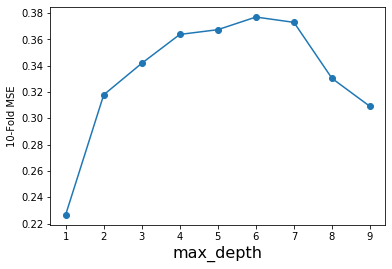

In [99]:
maxDepth = range(1,10)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 10)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

In [100]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))

Train:  0.46040616307491256


best mean cross-validation score: 0.503
best parameters: {'max_depth': 23}


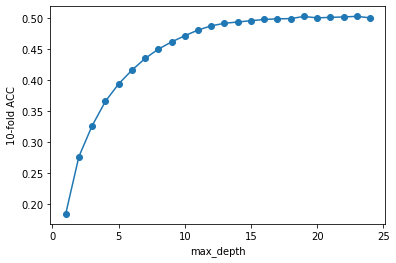

In [102]:
maxDepth = range(1,25)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()
#best mean cross-validation score: 0.503
#best parameters: {'max_depth': 23

In [103]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))

Train:  0.9260410457947388


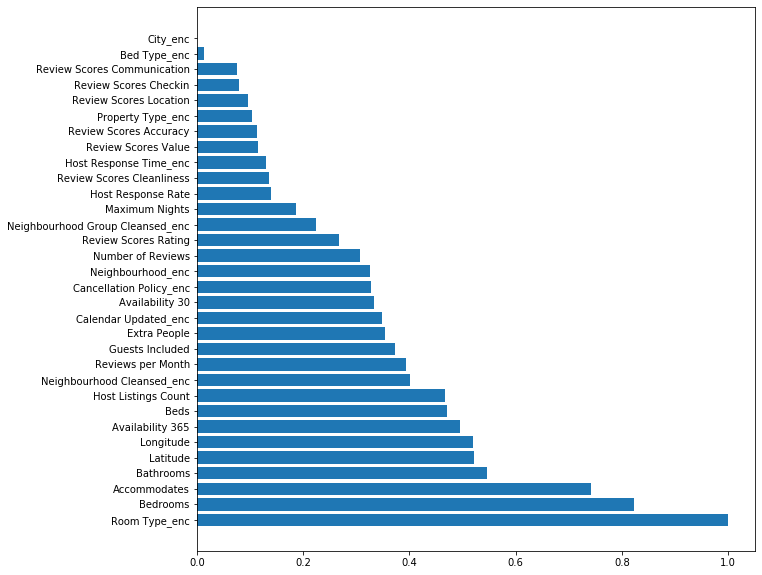

In [105]:
features = data.columns.drop(['Price_Penaliced'])

importances = bagModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

In [121]:
tscv = TimeSeriesSplit(n_splits=5)

alpha_vector = np.logspace(-4,4,20)
param_grid = {'alpha': alpha_vector}

grid = GridSearchCV(Lasso(), param_grid=param_grid, cv = tscv.split(X_train)).fit(X_train, y_train)

best mean cross-validation score: 0.391
best parameters: {'alpha': 0.012742749857031334}


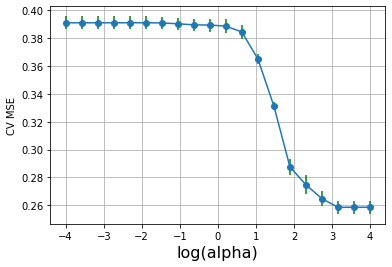

In [122]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(alpha_vector),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('CV MSE')
plt.grid()
plt.show()

Esta celda tarda mucho.

In [110]:
#Niterations = [500,1000,1500,2000]
Niterations = [500,1000,1500]
learningRate = [0.1,0.05]


param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=19), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.248
best parameters: {'learning_rate': 0.1, 'n_estimators': 500}


Esta celda tarda mucho.

In [114]:
vectorC = np.logspace(-2, 2, 10)
vectorG = np.logspace(-5, 1, 8)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv = 5, verbose=1)
grid.fit(XtrainScaled, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 32.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                         'gamma': array([1.00000000e-05, 7.19685673e-05, 5.17947468e-04, 3.72759372e-03,
       2.68269580e-02, 1.93069773e-01, 1.38949549e+00, 1.00000000e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

### REPETIR MODELO DESPUES DE EVALUAR LOS ANTERIORES

(aqui repito las trasnformaciones de arriba para eliminar mas abajo las variables que en los modelos vea que no influyen mucho o que pueden ser eliminadas)

In [124]:
data = pd.read_csv('./train.csv', sep=';', decimal='.')

aux_colums_toDrop = ['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 
                     'Experiences Offered', 'Notes', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url', 
                     'State', 'Market', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 'Host Location', 
                     'Host About', 'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url', 'Host Verifications', 
                     'Street','Smart Location', 'Country Code', 'Country', 'Weekly Price', 'Monthly Price', 
                     'Minimum Nights', 'Has Availability', 'Calendar last Scraped', 'First Review', 'Last Review', 
                     'License', 'Jurisdiction Names', 'Geolocation']
data = data.drop(aux_colums_toDrop, axis=1)
data = data.reindex(columns=(['Price'] + list([a for a in data.columns if a != 'Price']) ))

my_filter = data['Price'] <= 600
data = data[my_filter]

data = data.drop(['Host Total Listings Count', 'Calculated host listings count', 'Availability 60', 'Availability 90'], 
                 axis=1)

data = data.drop(['Square Feet'],axis=1)

data = data.drop(['Neighborhood Overview' , 'Transit', 'Interaction'],axis=1)

data['Access'].fillna(0, inplace=True)
data['Zipcode'].fillna(0, inplace=True)
data['Host Neighbourhood'].fillna(0, inplace=True)
data['Security Deposit'].fillna(0, inplace=True)
data['Cleaning Fee'].fillna(0, inplace=True)
data['Neighbourhood'].fillna('Unknown', inplace=True)
data['Amenities'].fillna(data['Amenities'].mode()[0], inplace=True)
data['Host Response Time'].fillna(data['Host Response Time'].mode()[0], inplace=True)
data['Host Response Rate'].fillna(data['Host Response Rate'].mode()[0], inplace=True)
data['Host Since'].fillna(data['Host Response Rate'].mode()[0], inplace=True)
data['Host Listings Count'].fillna(data['Host Listings Count'].mean(), inplace=True)
data['Bathrooms'].fillna(data['Bathrooms'].mean(), inplace=True)
data['Bedrooms'].fillna(data['Bedrooms'].mean(), inplace=True)
data['Beds'].fillna(data['Beds'].mean(), inplace=True)
data['Review Scores Rating'].fillna(data['Review Scores Rating'].mean(), inplace=True)
data['Review Scores Accuracy'].fillna(data['Review Scores Accuracy'].mean(), inplace=True)
data['Review Scores Cleanliness'].fillna(data['Review Scores Cleanliness'].mean(), inplace=True)
data['Review Scores Checkin'].fillna(data['Review Scores Checkin'].mean(), inplace=True)
data['Review Scores Communication'].fillna(data['Review Scores Communication'].mean(), inplace=True)
data['Review Scores Location'].fillna(data['Review Scores Location'].mean(), inplace=True)
data['Review Scores Value'].fillna(data['Review Scores Value'].mean(), inplace=True)
data['Reviews per Month'].fillna(data['Reviews per Month'].mean(), inplace=True)

data['Price_Penaliced'] = data[['Price','Security Deposit','Cleaning Fee']].sum(axis=1)

data = data.drop(['Price','Security Deposit','Cleaning Fee'],axis=1)

data = data.reindex(columns=(['Price_Penaliced'] + list([a for a in data.columns if a != 'Price_Penaliced']) ))

data = data.drop(['Access' , 'Amenities', 'Features', 'Host Since', 'Host Neighbourhood', 'Zipcode'],axis=1)

mean = data['Price_Penaliced'].mean()

agg = data.groupby('Neighbourhood')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Neighbourhood_enc'] = data['Neighbourhood'].map(smooth)


agg = data.groupby('Host Response Time')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Host Response Time_enc'] = data['Host Response Time'].map(smooth)


agg = data.groupby('Room Type')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Room Type_enc'] = data['Room Type'].map(smooth)


agg = data.groupby('Bed Type')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Bed Type_enc'] = data['Bed Type'].map(smooth)


agg = data.groupby('Cancellation Policy')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Cancellation Policy_enc'] = data['Cancellation Policy'].map(smooth)


agg = data.groupby('Property Type')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Property Type_enc'] = data['Property Type'].map(smooth)


agg = data.groupby('Neighbourhood Cleansed')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Neighbourhood Cleansed_enc'] = data['Neighbourhood Cleansed'].map(smooth)


agg = data.groupby('Neighbourhood Group Cleansed')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Neighbourhood Group Cleansed_enc'] = data['Neighbourhood Group Cleansed'].map(smooth)


agg = data.groupby('Calendar Updated')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Calendar Updated_enc'] = data['Calendar Updated'].map(smooth)


agg = data.groupby('City')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'City_enc'] = data['City'].map(smooth)

data = data.drop(['City' , 'Calendar Updated', 'Neighbourhood Group Cleansed', 'Neighbourhood Cleansed', 'Property Type', 
                 'Cancellation Policy', 'Bed Type', 'Room Type', 'Host Response Time', 'Neighbourhood'],axis=1)

Crear nuevas variables.

Voy a crear una nueva variable que unifique las son muy bajas en los modelos realizados.

In [126]:
data['Review_collection'] = data[['Review Scores Checkin','Review Scores Communication','Review Scores Location']].mean(axis=1)

Ultimos drop()

In [130]:
data = data.drop(['Review Scores Checkin','Review Scores Communication','Review Scores Location',
                  'City_enc', 'Bed Type_enc'],axis=1)

In [141]:
data_train = data.values
y_train = data_train[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data_train[:,1:]      # nos quedamos con el resto
feature_names = data.columns[1:]

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

best mean cross-validation score: 0.504
best parameters: {'max_depth': 23}


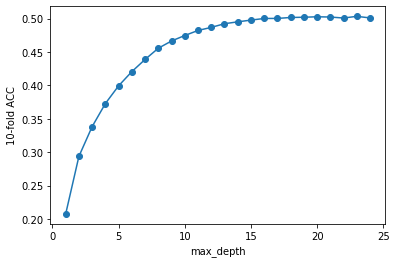

In [142]:
maxDepth = range(1,25)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [143]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))

Train:  0.928604960775179


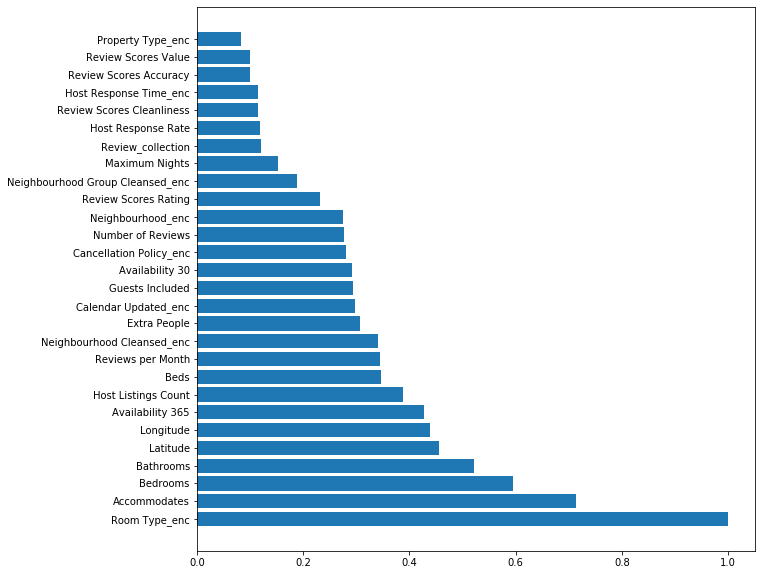

In [144]:
features = data.columns.drop(['Price_Penaliced'])

importances = bagModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

APLICAR TODAS LAS TRANSFORMACIONES ANTERIORES AL DATAFRAME DE TEST

In [153]:
data = pd.read_csv('./test.csv', sep=';', decimal='.')
# aplicarle LAS MISMAS transformaciones que hayáis hecho en train 
#(drop de columnas, filtros, generaciones, fill...) y sacar los datos:

aux_colums_toDrop = ['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 
                     'Experiences Offered', 'Notes', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url', 
                     'State', 'Market', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 'Host Location', 
                     'Host About', 'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url', 'Host Verifications', 
                     'Street','Smart Location', 'Country Code', 'Country', 'Weekly Price', 'Monthly Price', 
                     'Minimum Nights', 'Has Availability', 'Calendar last Scraped', 'First Review', 'Last Review', 
                     'License', 'Jurisdiction Names', 'Geolocation']

data = data.drop(aux_colums_toDrop, axis=1)
data = data.reindex(columns=(['Price'] + list([a for a in data.columns if a != 'Price']) ))

my_filter = data['Price'] <= 600
data = data[my_filter]

data = data.drop(['Host Total Listings Count', 'Calculated host listings count', 'Availability 60', 'Availability 90'], 
                 axis=1)

data = data.drop(['Square Feet'],axis=1)

data = data.drop(['Neighborhood Overview' , 'Transit', 'Interaction'],axis=1)

data['Access'].fillna(0, inplace=True)
data['Zipcode'].fillna(0, inplace=True)
data['Host Neighbourhood'].fillna(0, inplace=True)
data['Security Deposit'].fillna(0, inplace=True)
data['Cleaning Fee'].fillna(0, inplace=True)
data['Neighbourhood'].fillna('Unknown', inplace=True)
data['Amenities'].fillna(data['Amenities'].mode()[0], inplace=True)
data['Host Response Time'].fillna(data['Host Response Time'].mode()[0], inplace=True)
data['Host Response Rate'].fillna(data['Host Response Rate'].mode()[0], inplace=True)
data['Host Since'].fillna(data['Host Response Rate'].mode()[0], inplace=True)
data['Host Listings Count'].fillna(data['Host Listings Count'].mean(), inplace=True)
data['Bathrooms'].fillna(data['Bathrooms'].mean(), inplace=True)
data['Bedrooms'].fillna(data['Bedrooms'].mean(), inplace=True)
data['Beds'].fillna(data['Beds'].mean(), inplace=True)
data['Review Scores Rating'].fillna(data['Review Scores Rating'].mean(), inplace=True)
data['Review Scores Accuracy'].fillna(data['Review Scores Accuracy'].mean(), inplace=True)
data['Review Scores Cleanliness'].fillna(data['Review Scores Cleanliness'].mean(), inplace=True)
data['Review Scores Checkin'].fillna(data['Review Scores Checkin'].mean(), inplace=True)
data['Review Scores Communication'].fillna(data['Review Scores Communication'].mean(), inplace=True)
data['Review Scores Location'].fillna(data['Review Scores Location'].mean(), inplace=True)
data['Review Scores Value'].fillna(data['Review Scores Value'].mean(), inplace=True)
data['Reviews per Month'].fillna(data['Reviews per Month'].mean(), inplace=True)

data['Price_Penaliced'] = data[['Price','Security Deposit','Cleaning Fee']].sum(axis=1)

data = data.drop(['Price','Security Deposit','Cleaning Fee'],axis=1)

data = data.reindex(columns=(['Price_Penaliced'] + list([a for a in data.columns if a != 'Price_Penaliced']) ))

data = data.drop(['Access' , 'Amenities', 'Features', 'Host Since', 'Host Neighbourhood', 'Zipcode'],axis=1)

mean = data['Price_Penaliced'].mean()

agg = data.groupby('Neighbourhood')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Neighbourhood_enc'] = data['Neighbourhood'].map(smooth)


agg = data.groupby('Host Response Time')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Host Response Time_enc'] = data['Host Response Time'].map(smooth)


agg = data.groupby('Room Type')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Room Type_enc'] = data['Room Type'].map(smooth)


agg = data.groupby('Bed Type')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Bed Type_enc'] = data['Bed Type'].map(smooth)


agg = data.groupby('Cancellation Policy')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Cancellation Policy_enc'] = data['Cancellation Policy'].map(smooth)


agg = data.groupby('Property Type')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Property Type_enc'] = data['Property Type'].map(smooth)


agg = data.groupby('Neighbourhood Cleansed')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Neighbourhood Cleansed_enc'] = data['Neighbourhood Cleansed'].map(smooth)


agg = data.groupby('Neighbourhood Group Cleansed')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Neighbourhood Group Cleansed_enc'] = data['Neighbourhood Group Cleansed'].map(smooth)


agg = data.groupby('Calendar Updated')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'Calendar Updated_enc'] = data['Calendar Updated'].map(smooth)


agg = data.groupby('City')['Price_Penaliced'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means * weight *mean) / (counts + weight)
data.loc[:, 'City_enc'] = data['City'].map(smooth)

data = data.drop(['City' , 'Calendar Updated', 'Neighbourhood Group Cleansed', 'Neighbourhood Cleansed', 'Property Type', 
                 'Cancellation Policy', 'Bed Type', 'Room Type', 'Host Response Time', 'Neighbourhood'],axis=1)

data['Review_collection'] = data[['Review Scores Checkin','Review Scores Communication', 
                                        'Review Scores Location']].mean(axis=1)

data = data.drop(['Review Scores Checkin','Review Scores Communication','Review Scores Location',
                  'City_enc', 'Bed Type_enc'],axis=1)

PARTE MODELO TEST

In [154]:
data_test = data.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_train) 

In [157]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.9265828424554668
Test:  0.48218660305117345


Despues de probar varios modelos y cambiar el CV en ellos, los resultados que obtenia eran muy malos. No he sido capaz de sacar datos aceptables.

Creo que ante todo me falta preparacion para afrontar problemas como este dataset con tantos valores ausentes, y tantas variables que he tenido que directamente descartar al no saber como tratarlas (cadenas de caracteres, fechas, urls...).

He intentado realizar todo lo que se pedia para la practica, pero al tener que descartar tantos datos creo que no he podido trabajarlo correctamente. Perdi 2-3 dias intentando hacer algo con las columnas que tenian cadenas de caracteres pero no he podido.